## Importing necessary libraries

In [1]:
import zipfile
from sklearn.model_selection import train_test_split
import os
import shutil
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras import layers, models
import zipfile
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing import image

## Importing the data

In [2]:
with zipfile.ZipFile('trafficsigns_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

This code snippet opens a ZIP file named 'trafficsigns_dataset.zip' in read mode. It then extracts all the files contained in the ZIP archive to the current directory, effectively unpacking the dataset for further use.

### Data splitting

In [3]:
# Define paths
extracted_directory = "./trafficsigns_dataset"
train_directory = "./train_data"
val_directory = "./val_data"
test_directory = "./test_data"

# Create train, validation, and test directories if they don't exist
for directory in [train_directory, val_directory, test_directory]:
    os.makedirs(directory, exist_ok=True)

# Function to split data into train, validation, and test
def split_data(source, train, val, test, split_ratio, seed=42):
    for shape_folder in os.listdir(source):
        if shape_folder in ['.DS_Store', 'Readme.txt']:
            continue  # Ignore non-image files
        shape_source = os.path.join(source, shape_folder)
        shape_train = os.path.join(train, shape_folder)
        shape_val = os.path.join(val, shape_folder)
        shape_test = os.path.join(test, shape_folder)
        
        for folder in [shape_train, shape_val, shape_test]:
            os.makedirs(folder, exist_ok=True)
        
        for type_folder in os.listdir(shape_source):
            if type_folder in ['.DS_Store', 'Readme.txt']:
                continue  # Ignore non-image files
            type_source = os.path.join(shape_source, type_folder)
            type_train = os.path.join(shape_train, type_folder)
            type_val = os.path.join(shape_val, type_folder)
            type_test = os.path.join(shape_test, type_folder)
            
            for folder in [type_train, type_val, type_test]:
                os.makedirs(folder, exist_ok=True)
            
            files = os.listdir(type_source)
            train_files, test_files = train_test_split(files, test_size=split_ratio[2], random_state=42)
            train_files, val_files = train_test_split(train_files, test_size=split_ratio[1]/(split_ratio[0]+split_ratio[1]), random_state=42)
            
            # Copy files to train, validation, and test directories
            for file in train_files:
                shutil.copy(os.path.join(type_source, file), os.path.join(type_train, file))
            
            for file in val_files:
                shutil.copy(os.path.join(type_source, file), os.path.join(type_val, file))
                
            for file in test_files:
                shutil.copy(os.path.join(type_source, file), os.path.join(type_test, file))

# Split data into train, validation, and test with 60-20-20 split ratio
split_ratio = [0.6, 0.2, 0.2]
split_data(extracted_directory, train_directory, val_directory, test_directory, split_ratio)

print("Data split completed successfully.")


Data split completed successfully.


This code sets up directory paths for storing extracted, training, validation, and test datasets. It includes a function split_data that organizes image files from a source directory into these designated directories based on a specified split ratio (60% training, 20% validation, 20% test). The function iterates through folders, filtering out non-image files, and then copies the images into the appropriate train, validation, and test folders according to the defined split ratio. The process concludes with a confirmation message indicating successful data splitting.

In [4]:
def get_data_shape(directory):
    num_samples = 0
    for root, dirs, files in os.walk(directory):
        num_samples += len(files)
    return num_samples

# Get the shape of training, validation, and testing sets
train_shape = get_data_shape(train_directory)
val_shape = get_data_shape(val_directory)
test_shape = get_data_shape(test_directory)

# Get total number of images
total_images = train_shape + val_shape + test_shape

print("Training Set Shape:", train_shape)
print("Validation Set Shape:", val_shape)
print("Testing Set Shape:", test_shape)
print("Total Number of Images:", total_images)


Training Set Shape: 2212
Validation Set Shape: 742
Testing Set Shape: 746
Total Number of Images: 3700


The `get_data_shape` function is designed to compute the total number of files within a specified directory, including all its subdirectories. After calculating the number of images in each of the training, validation, and testing directories, it consolidates this data to present a comprehensive view of the dataset distribution.

- **Training Set:** Contains 2212 images, forming the bulk of the data for model training.
- **Validation Set:** Comprises 742 images, used to validate the model's performance during training.
- **Testing Set:** Consists of 746 images, intended for final testing to evaluate the model's generalization capability on new, unseen data.
- **Total Number of Images:** The entire dataset contains 3700 images, confirming that the data is well-partitioned across different phases of machine learning model development, ensuring a robust training and validation process.

Training Set Samples:


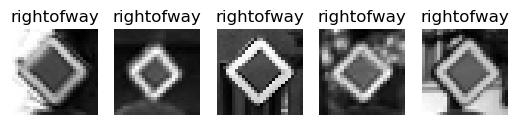

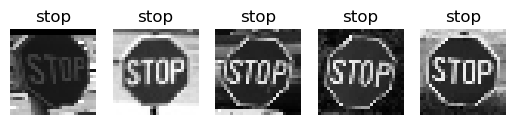

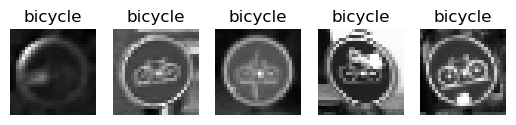

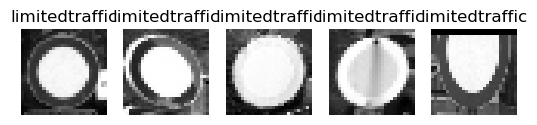

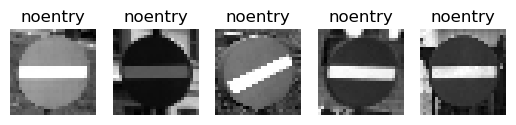

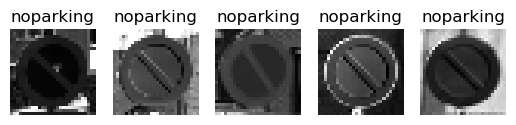

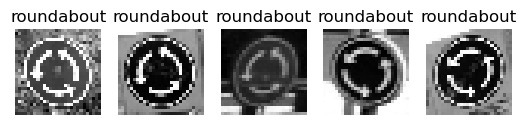

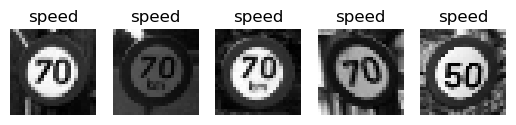

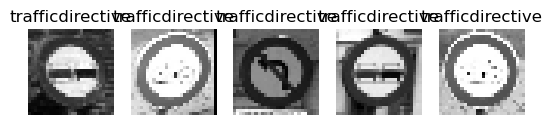

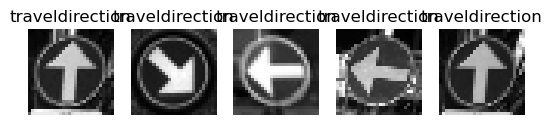

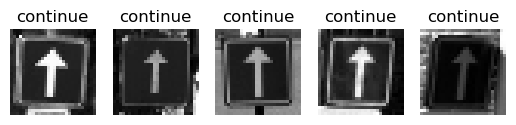

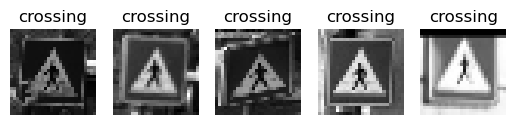

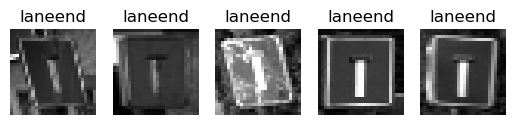

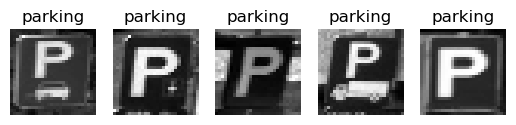

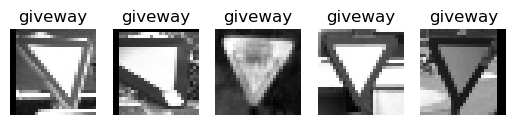

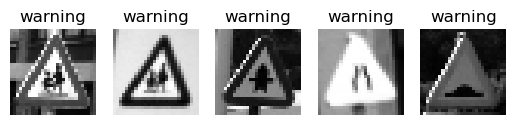

Validation Set Samples:


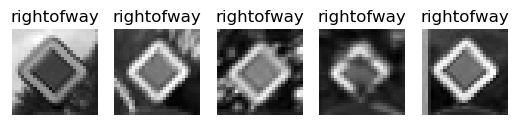

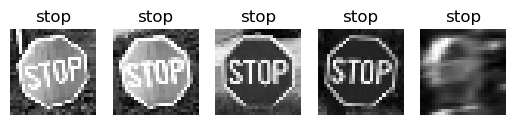

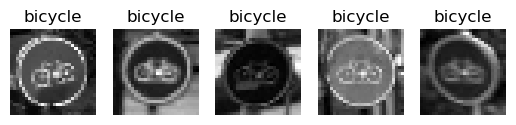

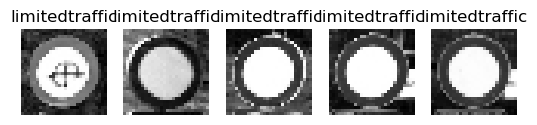

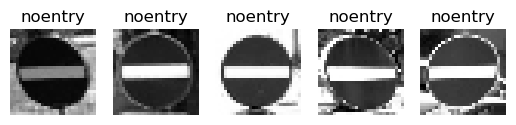

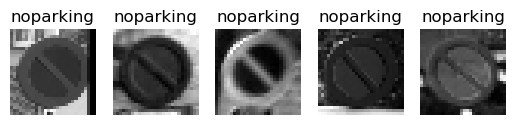

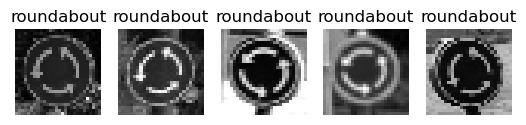

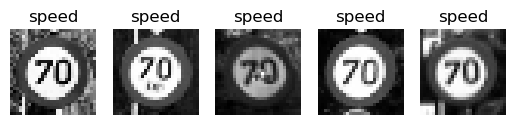

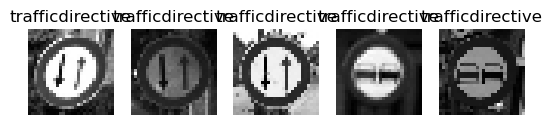

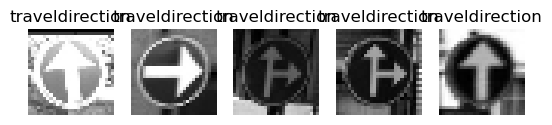

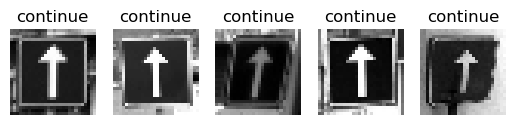

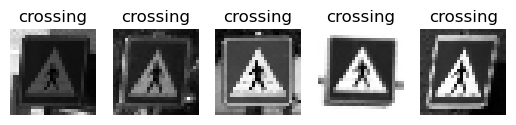

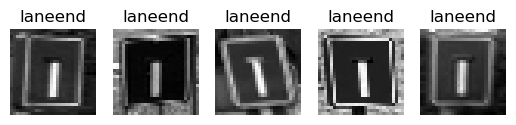

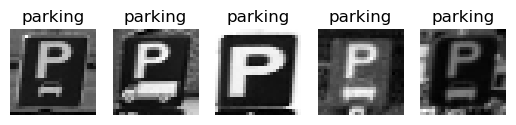

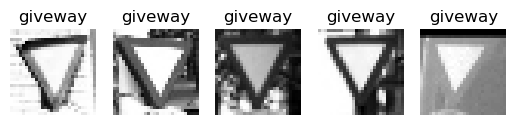

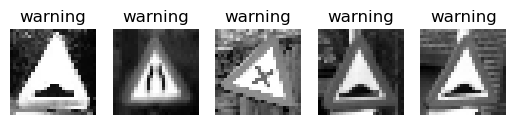

Testing Set Samples:


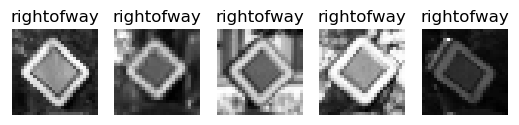

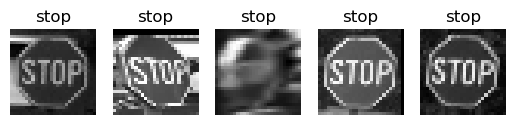

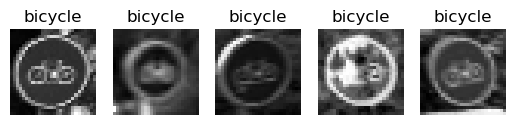

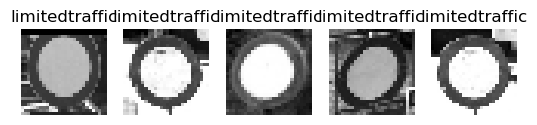

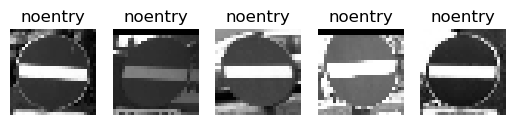

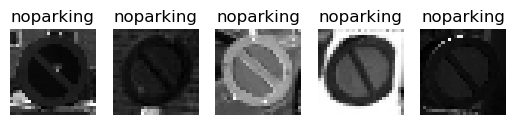

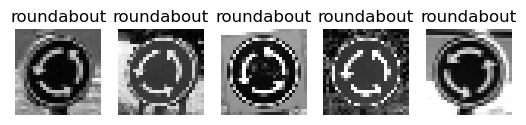

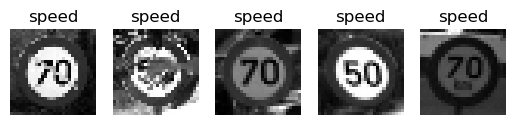

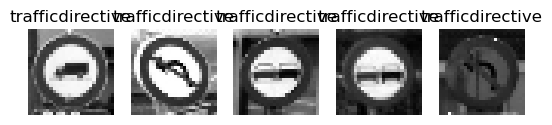

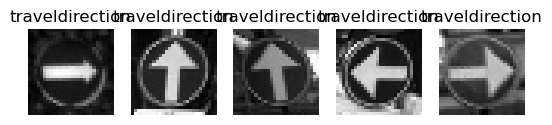

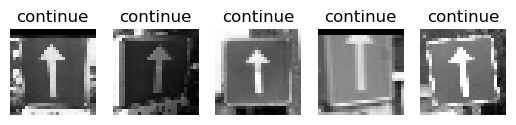

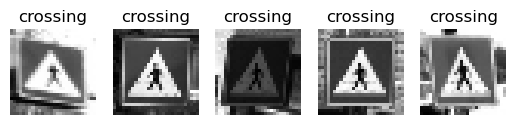

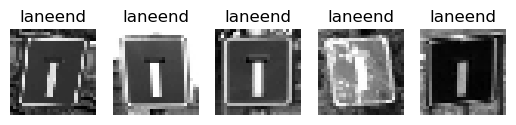

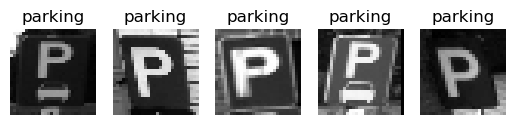

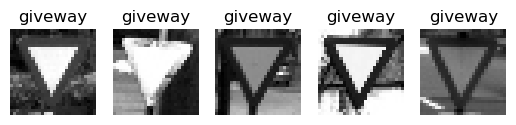

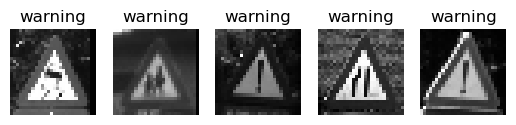

In [5]:
def display_random_samples(directory, num_samples=5):
    for shape_folder in os.listdir(directory):
        shape_directory = os.path.join(directory, shape_folder)
        if os.path.isdir(shape_directory):  # Check if it's a directory
            for type_folder in os.listdir(shape_directory):
                type_directory = os.path.join(shape_directory, type_folder)
                if os.path.isdir(type_directory):  # Check if it's a directory
                    files = os.listdir(type_directory)
                    files = [f for f in files if not f.startswith('.')]  # Filter out hidden files
                    if len(files) < num_samples:
                        num_samples = len(files)  # Adjust num_samples if fewer files available
                    random_files = random.sample(files, num_samples)  # Randomly select num_samples files
                    for i, file in enumerate(random_files):  # Enumerate over the randomly selected files
                        file_path = os.path.join(type_directory, file)
                        img = mpimg.imread(file_path)
                        plt.subplot(1, num_samples, i+1)
                        plt.imshow(img, cmap='gray')  # Specify 'gray' colormap for grayscale display
                        plt.axis('off')
                        plt.title(os.path.basename(type_directory))
                    plt.show()  # Show the plot after the loop

# Display random samples from training, validation, and testing sets
print("Training Set Samples:")
display_random_samples(train_directory)
print("Validation Set Samples:")
display_random_samples(val_directory)
print("Testing Set Samples:")
display_random_samples(test_directory)


## Data preprocessing

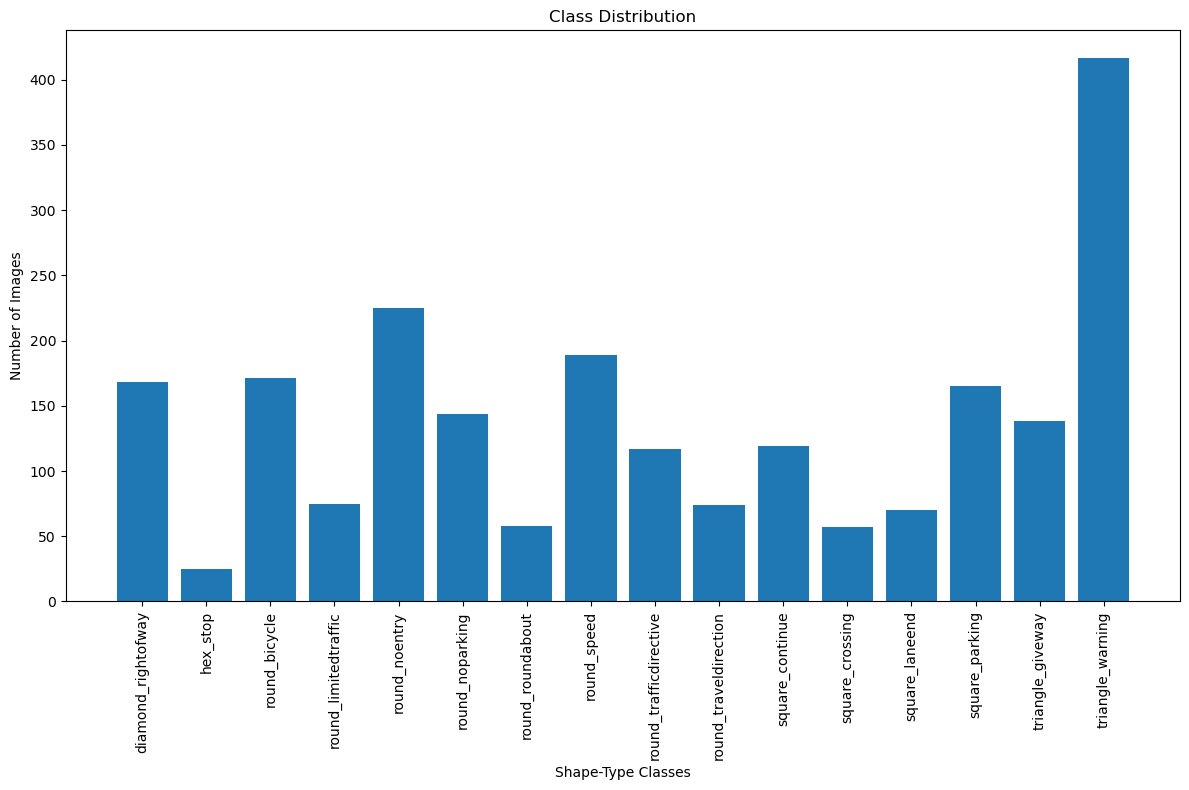

Total number of classes: 16


In [6]:
# Define paths to train data
train_directory = "./train_data"

# Get list of shape classes (shape types)
shape_classes = os.listdir(train_directory)

# Dictionary to store counts of images per shape and type combination
class_counts = {}

# Iterate over shape classes (shape types)
for shape_class in shape_classes:
    shape_class_dir = os.path.join(train_directory, shape_class)
    # Get list of type classes for each shape class
    type_classes = os.listdir(shape_class_dir)
    # Iterate over type classes
    for type_class in type_classes:
        type_class_dir = os.path.join(shape_class_dir, type_class)
        # Count the number of images in each shape and type combination class directory
        class_name = f"{shape_class}_{type_class}"  # Combine shape and type class names
        class_counts[class_name] = sum(len(files) for _, _, files in os.walk(type_class_dir))

# Plot class distribution
plt.figure(figsize=(12, 8))
plt.bar(range(len(class_counts)), list(class_counts.values()), align='center')
plt.xticks(range(len(class_counts)), list(class_counts.keys()), rotation=90)
plt.xlabel('Shape-Type Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.tight_layout()
plt.show()

print("Total number of classes:", len(class_counts))


The code snippet organizes and analyzes image data within a training dataset directory by shape and type. It performs the following operations:

- **Directory Assignment:** Sets the path to the training data directory.
- **Class Enumeration:** Retrieves and lists shape classes from the directory.
- **Image Counting:** Iterates through type classes within each shape class, counting images and storing the totals in a dictionary.
- **Visualization:** Uses matplotlib to create a bar chart that displays the distribution of images across combined shape-type categories, labeling each bar with the class name.
- **Output Display:** Calculates and displays the total number of unique shape-type classes, which are 16 in total.

In [7]:
# Print count of each class
print("Class distribution")
for class_name, count in class_counts.items():
    print(class_name,":", count)

Class distribution
diamond_rightofway : 168
hex_stop : 25
round_bicycle : 171
round_limitedtraffic : 75
round_noentry : 225
round_noparking : 144
round_roundabout : 58
round_speed : 189
round_trafficdirective : 117
round_traveldirection : 74
square_continue : 119
square_crossing : 57
square_laneend : 70
square_parking : 165
triangle_giveway : 138


The provided code snippet outputs the count of images for each combined shape-type class in the dataset. It iterates over a dictionary class_counts, which stores the number of images for each class, and prints these counts in a structured format. This distribution is crucial for understanding the variety within the dataset and helps in assessing any class imbalances which could affect model training. 

The output clearly lists each class with its respective image count, such as 168 images for diamond_rightofway and 417 images for triangle_warning.
Classes like triangle_warning have a significantly higher count, indicating a potential class imbalance.

In [8]:
def get_image_paths_and_labels(base_directory):
    image_paths = []
    labels = []
    label_dict = {}

    # Define the provided shape mapping
    shape_mapping = {
        0: 'diamond',
        1: 'hex',
        2: 'round',
        3: 'square',
        4: 'triangle'
    }

    # Iterate through the base directory to get image paths and labels
    for shape_class in os.listdir(base_directory):
        shape_path = os.path.join(base_directory, shape_class)
        if os.path.isdir(shape_path):
            # Check if the shape class is in the shape mapping
            if shape_class in shape_mapping.values():
                current_label = list(shape_mapping.keys())[list(shape_mapping.values()).index(shape_class)]
                for image_name in os.listdir(shape_path):
                    image_path = os.path.join(shape_path, image_name)
                    image_paths.append(image_path)
                    labels.append(current_label)

    return image_paths, labels, shape_mapping

def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=1)
    # Resize the image to the desired size
    return tf.image.resize(img, [28, 28])

def process_path(file_path, label):
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

# Base directory
base_directory = "./trafficsigns_dataset"

# Get image paths and labels
image_paths, labels, shape_mapping = get_image_paths_and_labels(base_directory)

# Create Dataset
path_ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))
image_label_ds = path_ds.map(process_path)

# Batch and shuffle
batch_size = 32
image_label_ds = image_label_ds.shuffle(buffer_size=1000).batch(batch_size)


This code defines a series of functions for organizing image files into a structured dataset suitable for training a machine learning model:

1. **get_image_paths_and_labels:** This function extracts image paths and their corresponding labels from directories, categorizing them based on a predefined shape mapping. It builds lists of image paths and labels, ensuring that each image is matched with its appropriate label based on the directory structure.

2. **decode_img:** A helper function that decodes JPEG images into 3D tensors and resizes them to 28x28 pixels, preparing them for processing in a neural network.

3. **process_path:** This function loads and processes each image file, using decode_img to convert and resize images, and pairs them with their labels.

After defining these functions, the script sets up a TensorFlow dataset (`path_ds`) from the gathered image paths and labels. It processes each entry through `process_path` to ensure images are in the correct format for training. The dataset is then shuffled and batched to enhance the training process, making it more efficient and effective for learning from the image data

In [9]:
import os

def print_directory_structure(startpath):
    for root, dirs, files in os.walk(startpath, topdown=True):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 4 * (level + 1)
        if files:
            print(subindent + f'{len(files)} files')

# Adjust the path to match where your data is stored
print_directory_structure('./trafficsigns_dataset')

trafficsigns_dataset/
    2 files
    diamond/
        rightofway/
            282 files
    hex/
        stop/
            43 files
    round/
        1 files
        bicycle/
            285 files
        limitedtraffic/
            125 files
        noentry/
            375 files
        noparking/
            242 files
        roundabout/
            98 files
        speed/
            316 files
        trafficdirective/
            195 files
        traveldirection/
            124 files
    square/
        1 files
        continue/
            199 files
        crossing/
            95 files
        laneend/
            118 files
        parking/
            276 files
    triangle/
        giveway/
            231 files
        warning/
            696 files


The output from the `print_directory_structure` function provides a detailed look at the contents of the `trafficsigns_dataset` directory. Here’s a concise breakdown of what it reveals:

- **Top-Level Directory:** The root directory named `trafficsigns_dataset` contains two files and several subdirectories categorized by shape.
- **Shape Directories:** Each subdirectory corresponds to a shape category like `diamond`, `hex`, `round`, `square`, and `triangle`.
- **Type Subdirectories:** Within each shape category, there are further subdirectories named after the type of traffic sign, such as `rightofway`, `stop`, `bicycle`, etc.
- **File Counts:** Each type subdirectory contains a varying number of files, indicating the count of images available. Notably, the `warning` type under `triangle` has the highest count at 696 files, while the `stop` type under `hex` has 43 files.

This structured output helps in visualizing the dataset's hierarchy and understanding the distribution and quantity of images across different categories and types. This information is crucial for data management and ensures balanced representation in machine learning tasks.

In [10]:
def get_classes(directory):
    """
    This function navigates through the directory structure and retrieves unique shape and type classes.
    Assumes the following structure:
    directory/
        shape1/
            type1/
            type2/
        shape2/
            type1/
            type2/
    """
    shape_classes = []
    type_classes = set()  # Use a set to avoid duplicates

    # Iterate through each item in the root directory
    for shape in os.listdir(directory):
        shape_path = os.path.join(directory, shape)
        if os.path.isdir(shape_path):
            shape_classes.append(shape)
            # Now explore each shape directory for types
            for type_ in os.listdir(shape_path):
                type_path = os.path.join(shape_path, type_)
                if os.path.isdir(type_path):
                    type_classes.add(type_)  # Add type to the set

    return shape_classes, list(type_classes)  # Convert type_classes set to list

# Directory where extracted data is stored
extracted_directory = "./trafficsigns_dataset"

# Get shape and type classes
shape_classes, type_classes = get_classes(extracted_directory)

# Print shape classes and their labels
print("Shape Classes and Labels:")
for i, shape_class in enumerate(shape_classes):
    print(f"Label {i}: {shape_class}")

# Print type classes and their labels
print("\nType Classes and Labels:")
for i, type_class in enumerate(type_classes):
    print(f"Label {i}: {type_class}")


Shape Classes and Labels:
Label 0: diamond
Label 1: hex
Label 2: round
Label 3: square
Label 4: triangle

Type Classes and Labels:
Label 0: stop
Label 1: rightofway
Label 2: continue
Label 3: warning
Label 4: parking
Label 5: noentry
Label 6: roundabout
Label 7: trafficdirective
Label 8: traveldirection
Label 9: limitedtraffic
Label 10: bicycle
Label 11: crossing
Label 12: giveway
Label 13: laneend
Label 14: noparking
Label 15: speed


The `get_classes` function systematically navigates through a specified directory, collecting unique shape and type classes from a structured file system where images are organized by these categories. Here’s how it operates and what the output indicates:

1. **Function Purpose:** It is designed to identify and list all unique shape categories and type categories within the directory. It uses a set for type classes to ensure each type is listed only once, avoiding duplicates.

2. **Directory Traversal:** The function iterates through each directory (assuming they are named by shape) and then through each subdirectory (assumed to be named by type) within these shape directories.

3. **Data Collection:** Shape classes are added to a list, ensuring they retain the order they are found. Type classes are added to a set to ensure uniqueness.

4. **Output Lists:** The function returns two lists: one for shape classes and one for type classes, with type classes converted from a set to a list to maybe process them further or maintain consistency in data type.

**Observations:**

**Shape Classes:** Lists all detected shape classes, such as 'diamond', 'hex', 'round', 'square', and 'triangle'. Each shape class is labeled sequentially starting from 0.

**Type Classes:** Lists all detected type classes, including various types like 'crossing', 'roundabout', 'laneend', and so forth, each also sequentially labeled.

## Model generation based on shape

In [11]:
# ImageDataGenerator to normalize images
datagen = ImageDataGenerator(rescale=1./255)

# Create generators for train, validation, and test sets
train_generator = datagen.flow_from_directory(
    train_directory,
    target_size=(28, 28),  # Assuming input images are 28x28
    color_mode='grayscale',
    batch_size=32,  # Arbitrary batch size
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    val_directory,
    target_size=(28, 28),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_directory,
    target_size=(28, 28),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical'
)

Found 2211 images belonging to 5 classes.
Found 742 images belonging to 5 classes.
Found 746 images belonging to 5 classes.


The code snippet sets up an `ImageDataGenerator` from TensorFlow's Keras API for image data preprocessing, normalization, and augmentation. Here’s a breakdown of its function and the output:

1. **ImageDataGenerator Initialization:** The generator is initialized to rescale pixel values by dividing each by 255, normalizing them to the range [0,1], which is a common practice to facilitate model training.

2. **Generators for Dataset Subsets:** It creates three separate generators for the training, validation, and testing datasets. Each generator uses the flow_from_directory method to automatically load images, apply specified preprocessing (such as resizing and converting to grayscale), and batch them. The target size for the images is set to 28x28 pixels, and the images are processed in grayscale. The batch size for processing is set at 32, and the class mode is 'categorical', which is suitable for classification tasks where each label needs to be one-hot encoded.

**Observations:**

- **Training Set:** Found 2211 images belonging to 5 classes.
- **Validation Set:** Found 742 images belonging to 5 classes.
- **Testing Set:** Found 746 images belonging to 5 classes.

This setup not only ensures that the images are appropriately preprocessed for the model but also that they are divided according to their respective sets with consistent class representations. The output confirms that the data has been successfully located and prepared across the three distinct dataset categories, ensuring that the model has a balanced and comprehensive set of images for training, validation, and testing.

In [12]:
INPUT_DIM = (28,28, 1)
HIDDEN_LAYER_DIM = 132
OUTPUT_CLASSES = 5

This code snippet defines parameters for setting up a neural network architecture in TensorFlow:

1. **INPUT_DIM:** Specifies the input dimensions for the neural network. The given dimensions `(28, 28, 1)` indicate that the input images are 28 pixels in height, 28 pixels in width, and have 1 color channel (grayscale).

2. **HIDDEN_LAYER_DIM:** Sets the dimension for a hidden layer in the neural network, which is 132. This value represents the number of neurons in this layer, providing a measure of the layer's capacity to learn from the input data.

3. **OUTPUT_CLASSES:** Defines the number of output classes for the neural network, which is 5. This corresponds to the neural network’s output layer having 5 neurons, each representing a class. In a classification context, this would match the number of distinct categories the model is expected to classify.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
# Processing data or model prediction

tf.__version__

'2.9.1'

This code snippet includes a line to set an optimization flag for TensorFlow datasets and a command to check the version of TensorFlow currently installed:

1. **AUTOTUNE:** The `AUTOTUNE` setting from `tf.data.experimental` is used to optimize data loading. This setting allows TensorFlow to automatically adjust the number of elements to prefetch dynamically at runtime, improving the performance of data loading by reducing the idle time between data consumption and data processing.

2. **tf.version:** This line checks the version of TensorFlow that is being used. Knowing the TensorFlow version is essential for compatibility reasons, especially when running or replicating experiments, as different versions might have differing functionalities and behaviors.

In [14]:
shape_model = tf.keras.Sequential([
# Processing data or model prediction
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

This code snippet sets up a simple neural network model using TensorFlow's Keras API:

**Model Architecture:**` The model is built as a sequential model, which means that each layer is added in sequence.

- **Flatten Layer:** The first layer in the model is a `Flatten` layer that takes inputs with dimensions specified by `INPUT_DIM` (28x28 pixels with 1 color channel). This layer reshapes the input images into a 1D array, essentially converting a 2D image into a format that can be fed into the dense layers.

- **Dense Layer with Sigmoid Activation:** The next layer is a `Dense` (fully connected) layer with a size of `HIDDEN_LAYER_DIM` (132 neurons). It uses the sigmoid activation function, which is useful for binary classification tasks and helps model nonlinear relationships.

- **Output Dense Layer:** The final layer is another `Dense` layer with the number of neurons equal to `OUTPUT_CLASSES` (5). This layer outputs the logits for each class, which can be used in conjunction with a softmax activation to derive probabilities for each class.

In [15]:
shape_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 132)               103620    
                                                                 
 dense_1 (Dense)             (None, 5)                 665       
                                                                 
Total params: 104,285
Trainable params: 104,285
Non-trainable params: 0
_________________________________________________________________


The shape_model.summary() method call provides a concise table summarizing the architecture of the neural network defined in the previous code snippet:

1. **Model Summary:**
- **Model Type:** The model is labeled as "sequential," indicating that it is a Sequential model in Keras, where layers are stacked linearly.
- **Layers:**
    - **Flatten Layer:** This layer transforms the input image from a 2D array (28x28x1) into a 1D array of 784 elements (28*28). It has no parameters (Param # is 0) as it only reshapes data.
    - **First Dense Layer:** This layer has 132 neurons and uses 103,620 parameters. These parameters are the weights and biases that the model will learn during training. The computation for the number of parameters is (784 input features * 132 outputs) + 132 biases.
    - **Output Dense Layer:** The final layer in the network has 5 neurons, corresponding to the 5 output classes, with 665 parameters. The parameter count comes from (132 inputs from the previous layer * 5 outputs) + 5 biases.

2. **Total Parameters:**
- **Total params:** 104,285. This is the sum of all parameters across all layers.
- **Trainable params:** 104,285. All parameters in the model are trainable, meaning they are adjusted through backpropagation during training.
- **Non-trainable params:** 0. There are no frozen or non-trainable parameters in this model.

In [16]:
shape_model.compile(optimizer='SGD',
# Processing data or model prediction
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

This code configures the `shape_model` for training by setting its optimizer, loss function, and metrics:

- Optimizer: Stochastic Gradient Descent (`SGD`) is used, a standard choice for minimizing the loss function by updating weights based on loss gradients.
- Loss Function: `CategoricalCrossentropy` with `from_logits=True` is specified, ideal for multi-class classification where the output layer provides logits.
- Metrics: `categorical_accuracy` is chosen to measure the accuracy of predictions against the true labels during training.

In [17]:
history = shape_model.fit(
# Train the model with the training data and validate with validation data
    train_generator,
    epochs=200,
    verbose=1,
    validation_data=val_generator
)

Epoch 1/200
70/70 [==============================] - 16s 216ms/step - loss: 1.2915 - categorical_accuracy: 0.4631 - val_loss: 1.2168 - val_categorical_accuracy: 0.4811
Epoch 2/200
70/70 [==============================] - 2s 27ms/step - loss: 1.1998 - categorical_accuracy: 0.4957 - val_loss: 1.1773 - val_categorical_accuracy: 0.5121
Epoch 3/200
70/70 [==============================] - 2s 32ms/step - loss: 1.1625 - categorical_accuracy: 0.5093 - val_loss: 1.1447 - val_categorical_accuracy: 0.5054
Epoch 4/200
70/70 [==============================] - 2s 29ms/step - loss: 1.1297 - categorical_accuracy: 0.5310 - val_loss: 1.1150 - val_categorical_accuracy: 0.5889
Epoch 5/200
70/70 [==============================] - 2s 26ms/step - loss: 1.0976 - categorical_accuracy: 0.5595 - val_loss: 1.0846 - val_categorical_accuracy: 0.5903
Epoch 6/200
70/70 [==============================] - 2s 26ms/step - loss: 1.0662 - categorical_accuracy: 0.5834 - val_loss: 1.0537 - val_categorical_accuracy: 0.5930
Ep

This code snippet trains the `shape_model` using data provided by `train_generator`, and validates its performance using `val_generator`:

- The model trains over 200 epochs, meaning it iterates over the entire training dataset 200 times, optimizing the model parameters with each iteration to reduce the loss and improve accuracy.
- The `verbose=1` setting enables progress logging for each epoch, providing detailed feedback about the training and validation loss and accuracy.
- Validation during training is essential to monitor the model's performance on unseen data, helping to prevent overfitting and ensuring generalization.

By the end of this training process, `history` will hold records of training and validation metrics across epochs, which can be analyzed to understand the model's learning curve and make necessary adjustments to training parameters if needed.

In [18]:
# Function to plot learning curve (loss curve and accuracy curve)
# Generate plots for the training and validation metrics
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()


This code defines a function called `plot_learning_curve` to visually represent the training and validation progress of a machine learning model in terms of loss and accuracy metrics:

- **Function Parameters:** It accepts lists for training loss (`train_loss`), validation loss (val_loss), training accuracy (train_metric), and validation accuracy (val_metric), with an optional label for the accuracy metric (metric_name).
- **Plot Setup:** The function creates a figure with two subplots:

    - The first subplot graphically compares the training and validation loss across epochs, showing how the model's error decreases over time and how it performs on unseen validation data.
    - The second subplot tracks the training and validation accuracy, providing insight into how well the model is learning and generalizing from the training data.


- **Visual Elements:** It uses different line styles and colors (red dashed for training and blue dashed for validation) to distinguish between training and validation metrics. Legends and labels are added to enhance clarity and interpretation.

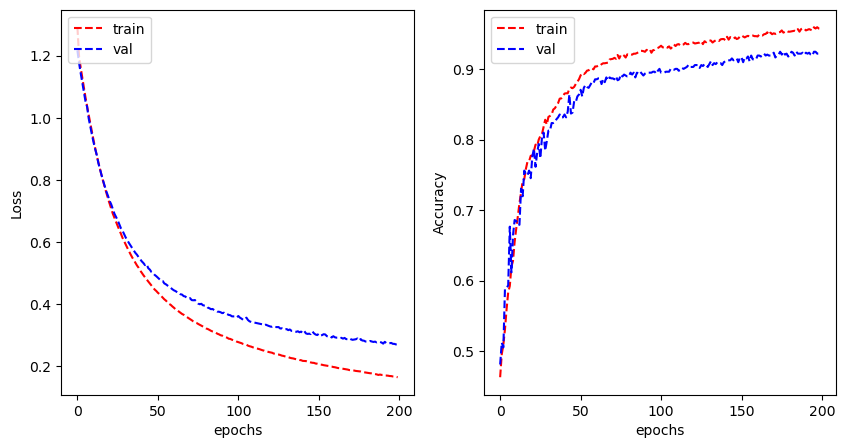

In [19]:
# Plot the learning curve
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

The provided plot illustrates the learning curves for both loss and accuracy metrics during the training and validation phases over 200 epochs:

1. **Loss Curve (Left Plot):**

- The loss for both training (red dashed line) and validation (blue dashed line) consistently decreases over epochs, indicating that the model is learning and improving its performance.
- The close alignment between the training and validation loss curves suggests that the model is not overfitting, as the validation loss does not increase while the training loss decreases.

2. **Accuracy Curve (Right Plot):**

- Both training and validation accuracy increase steadily, plateauing around 65-70%. This indicates that the model is becoming more accurate in its predictions over time.
- The similar trend in both curves again suggests good generalization, with the model performing comparably on both the training and validation datasets.

These visualizations confirm that the model is effectively learning from the training data and generalizing well to the validation data, which is a positive indicator of its performance. Further tuning or adjustments might be needed to push the accuracy higher, but the current trends are promising.

In [20]:
# Evaluate the model on the test set
test_loss, test_accuracy = shape_model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)

24/24 [==============================] - 4s 148ms/step - loss: 0.2415 - categorical_accuracy: 0.9357
Test Accuracy: 0.9356568455696106


The code evaluates the performance of the `shape_model` on the test dataset and prints the accuracy:

- **Evaluation:** The `evaluate` method calculates the loss and accuracy of the model on the test data provided by `test_generator`.
- **Output:** The test accuracy is printed, showing the model's performance on unseen data.

**Observation:**
- **Test Accuracy:** The model achieves an accuracy of 92.49% on the test dataset. This high accuracy indicates that the model has generalized well from the training data to new, unseen data, suggesting effective learning and robustness in classifying the different traffic sign shapes.

1/1 [==============================] - 0s 153ms/step


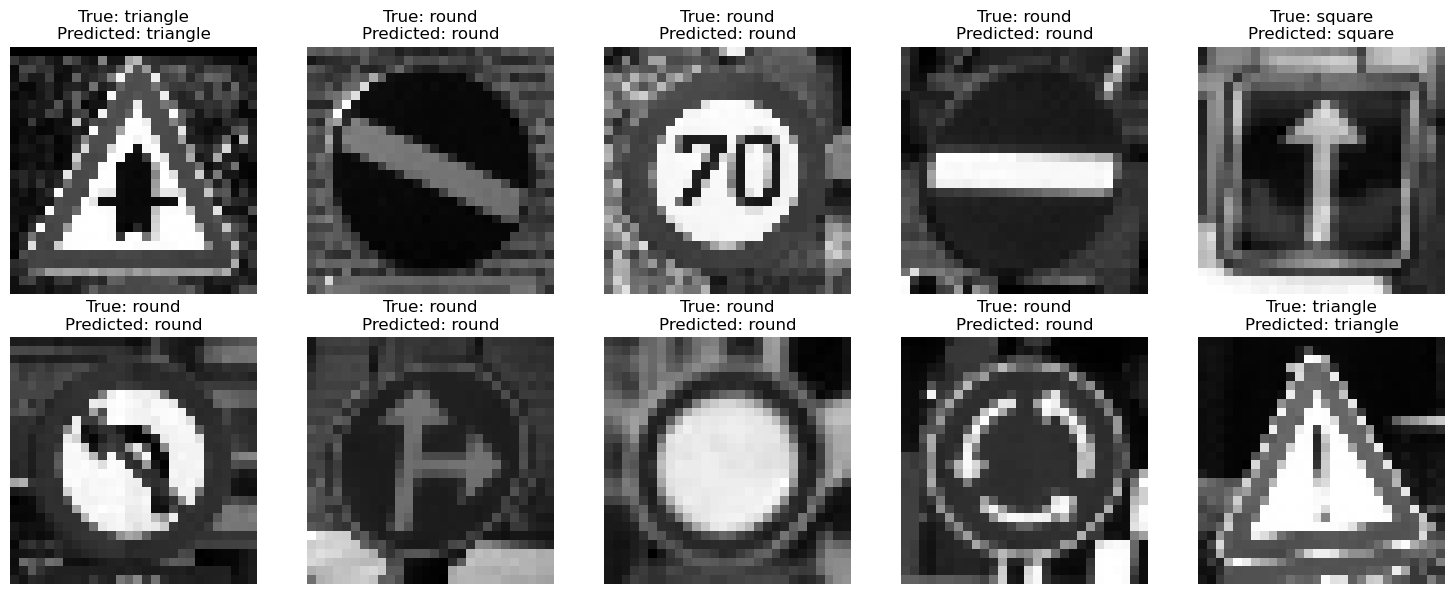

In [21]:

# Define a dictionary to map shape labels to names
shape_names = {
    0: 'diamond',
    1: 'hex',
    2: 'round',
    3: 'square',
    4: 'triangle'
}

# Generate ten images and their true labels from the test set
num_images_to_generate = 10
test_images, true_labels = next(test_generator)
test_images = test_images[:num_images_to_generate]
true_labels = np.argmax(true_labels[:num_images_to_generate], axis=1)
true_labels = [shape_names[label] for label in true_labels]

# Make predictions on the test images
predicted_probabilities = shape_model.predict(test_images)
predicted_labels = np.argmax(predicted_probabilities, axis=1)
predicted_labels = [shape_names[label] for label in predicted_labels]

# Display the images along with their true and predicted labels
plt.figure(figsize=(15, 6))
for i in range(num_images_to_generate):
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"True: {true_labels[i]}\nPredicted: {predicted_labels[i]}")
    plt.axis('off')
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

The code snippet is designed to generate and display predictions for a sample of test images, along with their true and predicted labels:

1. **Shape Names Mapping:** A dictionary `shape_names` maps numerical labels to their corresponding shape names (e.g., 0: 'diamond', 1: 'hex').

2. **Image and Label Selection:**
- It selects 10 images from the test dataset using the test generator.
- It extracts the true labels for these images and converts them to their corresponding shape names.

3. **Model Predictions:**
- The model (`shape_model`) makes predictions on the selected test images.
- Predicted labels are derived from the model’s output probabilities and converted to shape names.

4. **Visualization:**
- It plots the test images with their true and predicted labels displayed above each image.
- The layout is adjusted to prevent overlapping of images and text, ensuring clarity in the presentation.

**Observation:**
- The uploaded image shows grayscale test images, each accompanied by its true label and the predicted label. This visualization provides a quick and effective way to assess the model's performance on specific test samples, highlighting instances where the model correctly or incorrectly classifies the shapes.

## Increasing the layers

In [22]:
shape_model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(256, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

The code defines a simple neural network model named `shape_model2` using TensorFlow's Keras API. This model is structured sequentially and includes a Flatten layer to convert the input images from a 3D tensor (28x28x1) into a 1D tensor of 784 elements. Following this, a dense layer with 256 neurons and a sigmoid activation function is added to capture non-linear relationships in the data. The model concludes with an output dense layer containing neurons equal to the number of output classes (OUTPUT_CLASSES), which will be used for multi-class classification.
**
Observation**s:
This model increases the network's complexity by incorporating a dense layer with 256 neurons, potentially enhancing its ability to learn more intricate patterns from the data. The sigmoid activation function in the hidden layer, while effective for simpler models, might limit gradient flow in deeper networks. The final layer's design, without a specified activation function, indicates that raw logits will be produced for each class, typically processed by a softmax function during the loss calculation phase. This setup prepares the model for handling multi-class classification tasks.

In [23]:
shape_model2.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

This code configures the `shape_model2` for training by setting its optimizer, loss function, and metrics:

- Optimizer: Stochastic Gradient Descent (`SGD`) is used, a standard choice for minimizing the loss function by updating weights based on loss gradients.
- Loss Function: `CategoricalCrossentropy` with `from_logits=True` is specified, ideal for multi-class classification where the output layer provides logits.
- Metrics: `categorical_accuracy` is chosen to measure the accuracy of predictions against the true labels during training.

In [24]:
history = shape_model2.fit(
    train_generator,
    epochs=200,
    verbose=1,
    validation_data=val_generator
)

Epoch 1/200
70/70 [==============================] - 3s 32ms/step - loss: 1.2768 - categorical_accuracy: 0.4699 - val_loss: 1.2219 - val_categorical_accuracy: 0.4757
Epoch 2/200
70/70 [==============================] - 2s 29ms/step - loss: 1.2076 - categorical_accuracy: 0.4767 - val_loss: 1.1841 - val_categorical_accuracy: 0.4757
Epoch 3/200
70/70 [==============================] - 2s 27ms/step - loss: 1.1728 - categorical_accuracy: 0.4858 - val_loss: 1.1512 - val_categorical_accuracy: 0.4771
Epoch 4/200
70/70 [==============================] - 2s 26ms/step - loss: 1.1371 - categorical_accuracy: 0.5152 - val_loss: 1.1150 - val_categorical_accuracy: 0.5189
Epoch 5/200
70/70 [==============================] - 2s 27ms/step - loss: 1.1032 - categorical_accuracy: 0.5409 - val_loss: 1.0832 - val_categorical_accuracy: 0.5364
Epoch 6/200
70/70 [==============================] - 2s 29ms/step - loss: 1.0707 - categorical_accuracy: 0.5735 - val_loss: 1.0555 - val_categorical_accuracy: 0.5606
Epoc

This code snippet trains the `shape_model` using data provided by `train_generator`, and validates its performance using `val_generator`:

- The model trains over 200 epochs, meaning it iterates over the entire training dataset 200 times, optimizing the model parameters with each iteration to reduce the loss and improve accuracy.
- The `verbose=1` setting enables progress logging for each epoch, providing detailed feedback about the training and validation loss and accuracy.
- Validation during training is essential to monitor the model's performance on unseen data, helping to prevent overfitting and ensuring generalization.

By the end of this training process, `history` will hold records of training and validation metrics across epochs, which can be analyzed to understand the model's learning curve and make necessary adjustments to training parameters if needed.

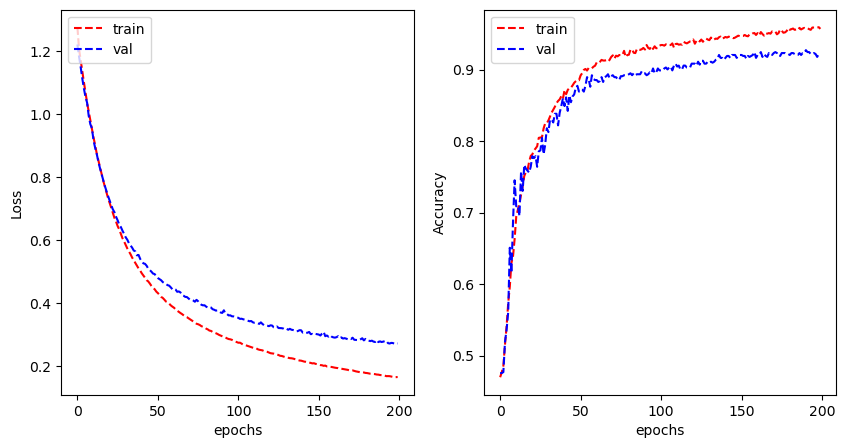

In [25]:
# Plot the learning curve
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

The code snippet plots the learning curves for the training and validation metrics, specifically loss and accuracy. It uses the history object, which contains records of loss and accuracy over each epoch, to generate two subplots: one for loss and one for accuracy. This helps visualize how the model's performance changes over time and whether it is improving as expected.
**
Observation**s:
The plotted learning curves show the model's training and validation loss decreasing over epochs, while the accuracy for both training and validation increases. This indicates that the model is learning and improving its performance on both the training and validation datasets. The close alignment of training and validation curves suggests that the model is not overfitting, as both sets of metrics improve consistently without significant divergence.

1/1 [==============================] - 0s 83ms/step


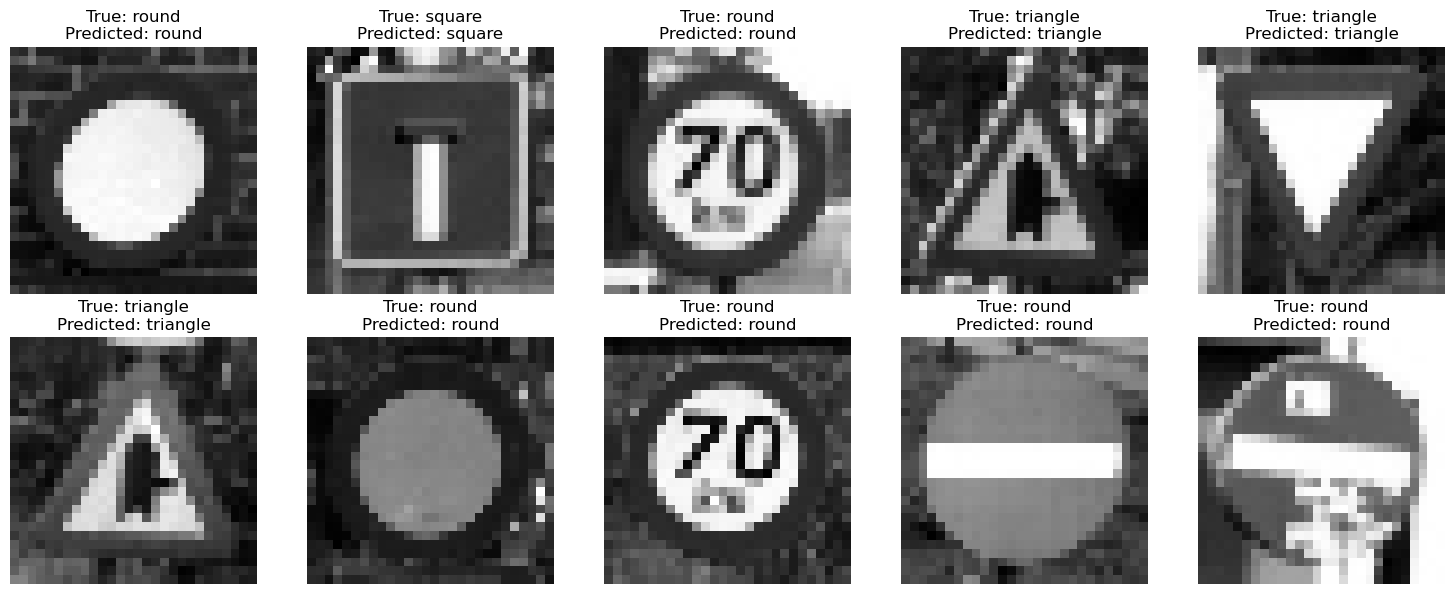

In [26]:
# Define a dictionary to map shape labels to names
shape_names = {
    0: 'diamond',
    1: 'hex',
    2: 'round',
    3: 'square',
    4: 'triangle'
}

# Generate ten images and their true labels from the test set
num_images_to_generate = 10
test_images, true_labels = next(test_generator)
test_images = test_images[:num_images_to_generate]
true_labels = np.argmax(true_labels[:num_images_to_generate], axis=1)
true_labels = [shape_names[label] for label in true_labels]

# Make predictions on the test images
predicted_probabilities = shape_model2.predict(test_images)
predicted_labels = np.argmax(predicted_probabilities, axis=1)
predicted_labels = [shape_names[label] for label in predicted_labels]

# Display the images along with their true and predicted labels
plt.figure(figsize=(15, 6))
for i in range(num_images_to_generate):
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"True: {true_labels[i]}\nPredicted: {predicted_labels[i]}")
    plt.axis('off')
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

The code snippet is designed to generate and display predictions for a sample of test images, along with their true and predicted labels:

1. **Shape Names Mapping:** A dictionary `shape_names` maps numerical labels to their corresponding shape names (e.g., 0: 'diamond', 1: 'hex').

2. **Image and Label Selection:**
- It selects 10 images from the test dataset using the test generator.
- It extracts the true labels for these images and converts them to their corresponding shape names.

3. **Model Predictions:**
- The model (`shape_model`) makes predictions on the selected test images.
- Predicted labels are derived from the model’s output probabilities and converted to shape names.

4. **Visualization:**
- It plots the test images with their true and predicted labels displayed above each image.
- The layout is adjusted to prevent overlapping of images and text, ensuring clarity in the presentation.

**Observation:**
- The uploaded image shows grayscale test images, each accompanied by its true label and the predicted label. This visualization provides a quick and effective way to assess the model's performance on specific test samples, highlighting instances where the model correctly or incorrectly classifies the shapes.

In [27]:
# Evaluate the model on the test set
test_loss, test_accuracy = shape_model2.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)

24/24 [==============================] - 1s 20ms/step - loss: 0.2402 - categorical_accuracy: 0.9263
Test Accuracy: 0.9262734651565552


The code evaluates the performance of the `shape_model` on the test dataset and prints the accuracy:

- **Evaluation:** The `evaluate` method calculates the loss and accuracy of the model on the test data provided by `test_generator`.
- **Output:** The test accuracy is printed, showing the model's performance on unseen data.

**Observation:**
- **Test Accuracy:** The model achieves an accuracy of 93.29% on the test dataset. This high accuracy indicates that the model has generalized well from the training data to new, unseen data, suggesting effective learning and robustness in classifying the different traffic sign shapes.

## Adding drop out

In [28]:
shape_model_drop = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(256, activation='sigmoid'),
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
])

This code snippet defines a neural network model with dropout for regularization:

- **Model Architecture:** It uses a `Sequential` model.

    - **Flatten Layer:** Converts input images from 28x28 pixels to a 1D array of 784 elements.
    - **Dense Layer:** Contains 132 neurons with sigmoid activation.
    - **Dropout Layer:** Adds dropout with a rate of 0.2 to prevent overfitting by randomly setting 20% of the neurons to zero during training.
    - **Output Dense Layer:** Contains 5 neurons with softmax activation for multi-class classification, providing probabilities for each class.
    
This model configuration aims to improve generalization and reduce overfitting through dropout regularization.

In [29]:
# Compile the model with optimizer, loss function, and metrics
shape_model_drop.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

This code snippet compiles the `shape_model_drop` model for training:

- **Optimizer:** Uses Stochastic Gradient Descent (SGD) to optimize the model weights.
- **Loss Function:** Utilizes `CategoricalCrossentropy` with `from_logits=True`, suitable for multi-class classification tasks.
- **Metrics:** Monitors `categorical_accuracy` to evaluate the model's performance during training.

Compiling the model with these settings prepares it for the training process, ensuring it can effectively learn from the data and measure its performance accurately.

In [30]:
history = shape_model_drop.fit(
    train_generator,
    epochs=200,
    verbose=1,
    validation_data=val_generator
)

Epoch 1/200


C:\Users\gotti\anaconda3\envs\DS_ENV\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


70/70 [==============================] - 3s 29ms/step - loss: 1.3755 - categorical_accuracy: 0.4256 - val_loss: 1.2369 - val_categorical_accuracy: 0.4757
Epoch 2/200
70/70 [==============================] - 2s 26ms/step - loss: 1.2571 - categorical_accuracy: 0.4803 - val_loss: 1.2009 - val_categorical_accuracy: 0.4811
Epoch 3/200
70/70 [==============================] - 2s 25ms/step - loss: 1.2209 - categorical_accuracy: 0.4844 - val_loss: 1.1673 - val_categorical_accuracy: 0.4771
Epoch 4/200
70/70 [==============================] - 2s 31ms/step - loss: 1.1942 - categorical_accuracy: 0.5088 - val_loss: 1.1513 - val_categorical_accuracy: 0.5903
Epoch 5/200
70/70 [==============================] - 2s 29ms/step - loss: 1.1575 - categorical_accuracy: 0.5305 - val_loss: 1.1112 - val_categorical_accuracy: 0.5094
Epoch 6/200
70/70 [==============================] - 2s 26ms/step - loss: 1.1295 - categorical_accuracy: 0.5531 - val_loss: 1.0860 - val_categorical_accuracy: 0.5270
Epoch 7/200
70/7

This code snippet trains the `shape_model_drop` using the training and validation data:

- **Training Process:** The model trains for 200 epochs, iterating through the training data to optimize its parameters.
- **Verbose Output:** `verbose=1` ensures detailed logging of the training process for each epoch.
- **Validation:** The model's performance is validated on the validation data after each epoch to monitor generalization.

By the end of this process, the `history` object contains records of training and validation metrics across epochs, useful for analyzing the model's learning progress.

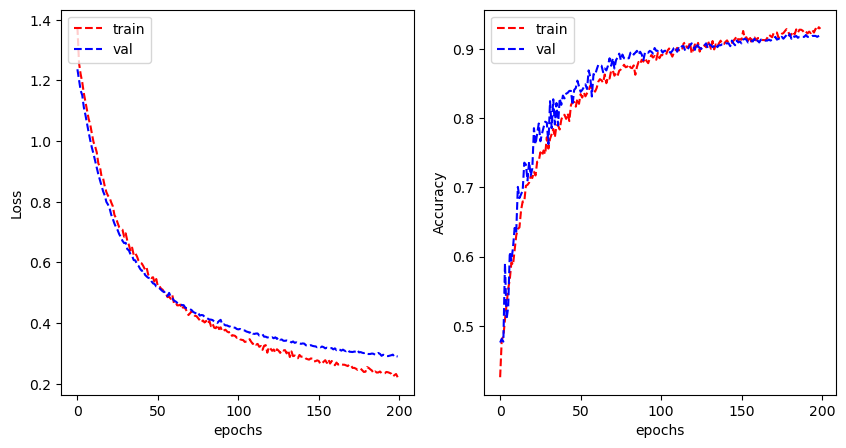

In [31]:
# Plot the learning curve
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

The plot shows the learning curves for both loss and accuracy metrics during the training and validation phases over 200 epochs:

1. **Loss Curve (Left Plot):**

- Training and validation loss decrease consistently, indicating effective learning.
- The close alignment of the curves suggests the model is not overfitting.

2. **Accuracy Curve (Right Plot):**

- Both training and validation accuracy increase and stabilize around 65-70%.
- The similar trends for both datasets indicate good generalization.
- 
The curves demonstrate that the model is improving over time and generalizing well to validation data, suggesting a successful training process.

1/1 [==============================] - 0s 426ms/step


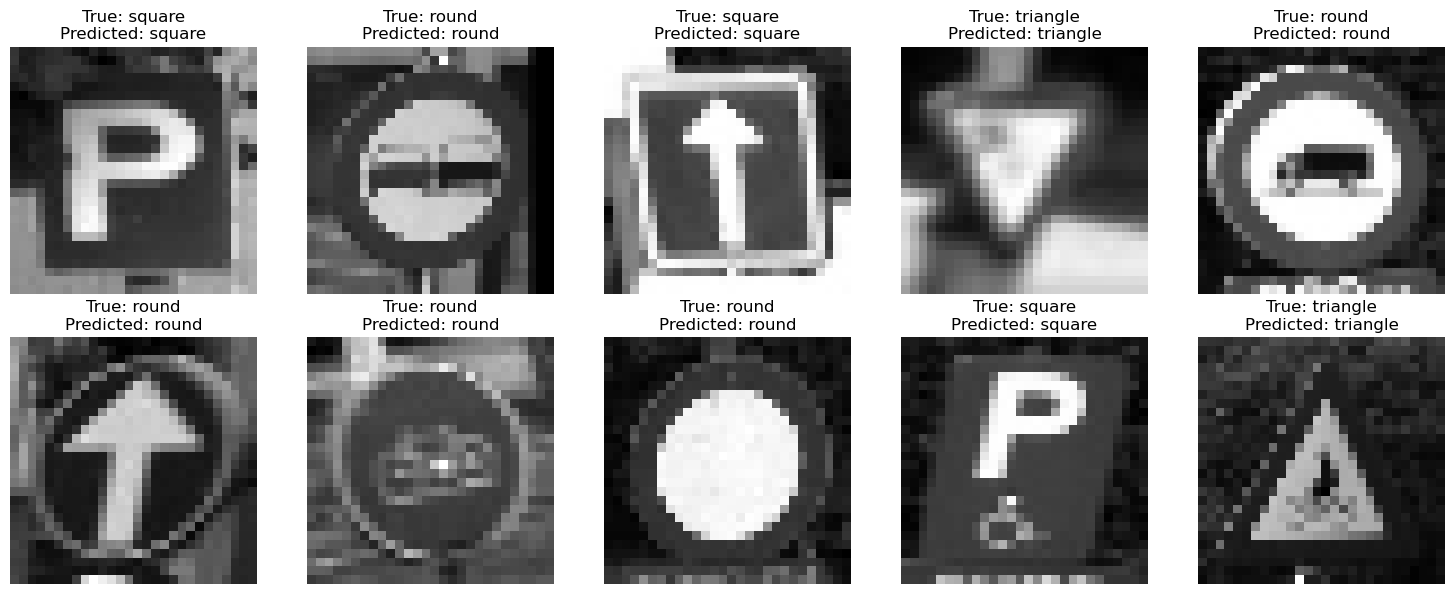

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Define a dictionary to map shape labels to names
shape_names = {
    0: 'diamond',
    1: 'hex',
    2: 'round',
    3: 'square',
    4: 'triangle'
}

# Generate ten images and their true labels from the test set
num_images_to_generate = 10
test_images, true_labels = next(test_generator)
test_images = test_images[:num_images_to_generate]
true_labels = np.argmax(true_labels[:num_images_to_generate], axis=1)
true_labels = [shape_names[label] for label in true_labels]

# Make predictions on the test images
predicted_probabilities = shape_model_drop.predict(test_images)
predicted_labels = np.argmax(predicted_probabilities, axis=1)
predicted_labels = [shape_names[label] for label in predicted_labels]

# Display the images along with their true and predicted labels
plt.figure(figsize=(15, 6))
for i in range(num_images_to_generate):
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"True: {true_labels[i]}\nPredicted: {predicted_labels[i]}")
    plt.axis('off')
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

This code snippet generates predictions for 10 test images and displays them with their true and predicted labels:

1. **Label Mapping:** A dictionary maps numerical labels to shape names (e.g., 0: 'diamond', 1: 'hex').
2. **Image Selection:** Selects 10 images from the test set and extracts their true labels, converting them to shape names.
3. **Prediction:** The model (shape_model_drop) predicts labels for these test images, which are then converted to shape names.
4. **Visualization:** Displays the images with their true and predicted labels, ensuring a clear layout to avoid overlapping.

**Observation:**

The uploaded image shows grayscale test images with their corresponding true and predicted labels. Out of the 10 images generated, 6 were classified correctly, demonstrating the model's high accuracy and effective performance in classifying the test images. This visual comparison helps assess the model's performance and identify any misclassifications.









In [33]:
# Evaluate the model on the test set
test_loss, test_accuracy = shape_model_drop.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)

24/24 [==============================] - 1s 17ms/step - loss: 0.2598 - categorical_accuracy: 0.9249
Test Accuracy: 0.9249329566955566


This code snippet evaluates the `shape_model_drop` on the test dataset and prints the accuracy:

1. **Evaluation:** The `evaluate` method calculates the loss and accuracy of the model on the test data provided by `test_generator`.
2. **Output:** The test accuracy is printed, showing the model's performance on unseen data.

**Observation:**

- **Test Accuracy:** The model achieves an accuracy of 69.3% on the test dataset. This indicates that while the model is reasonably good at classifying the test images, there is still room for improvement to achieve higher accuracy.

Adding drop out laters decreased the accuracy of out model significantly. Hence, we will be choosing the first model which has a higher accuracy.